## Spatial Analysis
Research in R for a project looking into the correlation between pollution (levels of PM2.5) and race (levels of diversity) in Los Angeles. This notebook contains code used to calculate spatial and statistical measures and to plot diagrams and figures for the resulting paper *'The effect of exposure to particulate matter on the racial diveristy of populations across Los Angeles'.*

### Package Installation

In [ ]:
install.packages(c('rgeos','rgdal','RColorBrewer','GISTools','raster','gstat','nlme','sp','geosphere','moments','plyr'))

In [2]:
options(warn=-1)
library(rgeos)
library(rgdal)
library(RColorBrewer)
library(GISTools)
library(raster)
library(gstat) 
library(nlme)
library(sp)
require(geosphere)
library(spdep)
library(spgwr)
library(GWmodel)
library(moments)
library(plotrix)
library(spatstat)
library(maptools)
library(plyr)

### Prep Pollution Data

Data has been collected from the California Environmental Protection Agency - these measures of particulate matter were taken from a total of 37 monitoring stations in the South Coast Air Basin, providing an hourly average each day throughout the month of April 2016.

In [3]:
#read pollution data
ozone = read.csv("data/OZONE_PICKDATA_2016-4-30.csv", header=T, sep=",")
partmat = read.csv("data/PM25HR_PICKDATA_2016-4-30.csv", header=T, sep=",")

#read shapefiles of EPA monitoring stations and the air basins
monitor <- readOGR(dsn="data/airmonitoringstations.shp", layer="airmonitoringstations")
Ca.AirBasin <- readOGR(dsn="data/CaAirBasin.shp",layer="CaAirBasin")

#extract points within the South coast
SC.monitor = monitor[monitor$AIRBASIN %in% c("South Coast"),]
SC.AirBasin = Ca.AirBasin[Ca.AirBasin$NAME %in% c("South Coast"),]

#reproject the data to a suitable projection (utm used here because of the scale of the analysis)
SC.monitor.t = spTransform(SC.monitor, CRS("+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 + towgs84=0,0,0"))
SC.AirBasin.t = spTransform(SC.AirBasin, CRS("+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0"))

OGR data source with driver: ESRI Shapefile 
Source: "data/airmonitoringstations.shp", layer: "airmonitoringstations"
with 296 features
It has 12 fields
OGR data source with driver: ESRI Shapefile 
Source: "data/CaAirBasin.shp", layer: "CaAirBasin"
with 15 features
It has 5 fields
Integer64 fields read as strings:  CAABA_ CAABA_ID 


### Prep Census Data
The census data was sourced from the American Community Survey. These frequencies of different races in census tracts throughout Los Angeles County are 5-year estimates based on Census 2010 data, with a 90% margin of error.
A new measure of *diversity* is calculated which is a percentage measure of those in the population who are not in the majority race.

In [4]:
#read california census tracts
all.tracts = shapefile("data/cb_2015_06_tract_500k.shp")

#reproject the data to match the projection of the pollution datasets (utm)
all.tracts.t = spTransform(all.tracts, CRS("+proj=longlat +datum=NAD83 +no_defs + ellps=GRS80 +towgs84=0,0,0"))

#extract census tracts that intersect with the sc air basin
SC.tracts.t <- intersect(all.tracts.t, SC.AirBasin.t)

#read in the census data and merge with census tracts
census.data = read.csv("data/ACS_14_5YR_B02001_with_ann.csv") #race
census2.data = read.csv("data/ACS_14_5YR_B19013_with_ann.csv") #income

#race data set up
race.data = census.data[,c("GEO.id", "HD01_VD01", "HD01_VD02","HD01_VD03", "HD01_VD04","HD01_VD05","HD01_VD06")]
colnames(race.data)[1:7] = c("AFFGEOID","Total","White","Black","AIndian","Asian","Hawaiian")
#delete unneccessary info
race.data <- race.data[c(-1),]

#function for getting diversity measure
getdiversity <- function(rowval) {
	n = rowval
	tempmax = max(as.numeric(as.character(race.data$White[n])),as.numeric(as.character(race.data$Black[n])),as.numeric(as.character(race.data$AIndian[n])),as.numeric(as.character(race.data$Asian[n])),as.numeric(as.character(race.data$Hawaiian[n])))
	diversity = tempmax / as.numeric(as.character(race.data$Total[n]))
	return(diversity)
} 


#add new measure onto dataset
Diversity <- matrix(, nrow=nrow(race.data))
for (i in 1:nrow(race.data)) {
	Diversity[i] = getdiversity(i)
}
race.data = cbind(race.data, Diversity)

#income data set up
income.data = census2.data[,c("GEO.id", "HD01_VD01")]
colnames(income.data)[1:2] = c("AFFGEOID","Income")

#change the name of GEO.id so it can be merged with shapefile
colnames(census.data)[1] = "AFFGEOID"

#merge the sc census tracts with the census data
SC.tracts.t = sp::merge(SC.tracts.t, race.data, by='AFFGEOID')
SC.tracts.t = sp::merge(SC.tracts.t, income.data, by='AFFGEOID')

#remove missing values
SC.tracts.t <- SC.tracts.t[complete.cases(SC.tracts.t$Diversity),]

### Air Basins of LA
First let's check out where our South Coast air basins are in LA, and we can project them on top of a choropleth map of our new diversity measure too to see if that is telling us anything interesting.

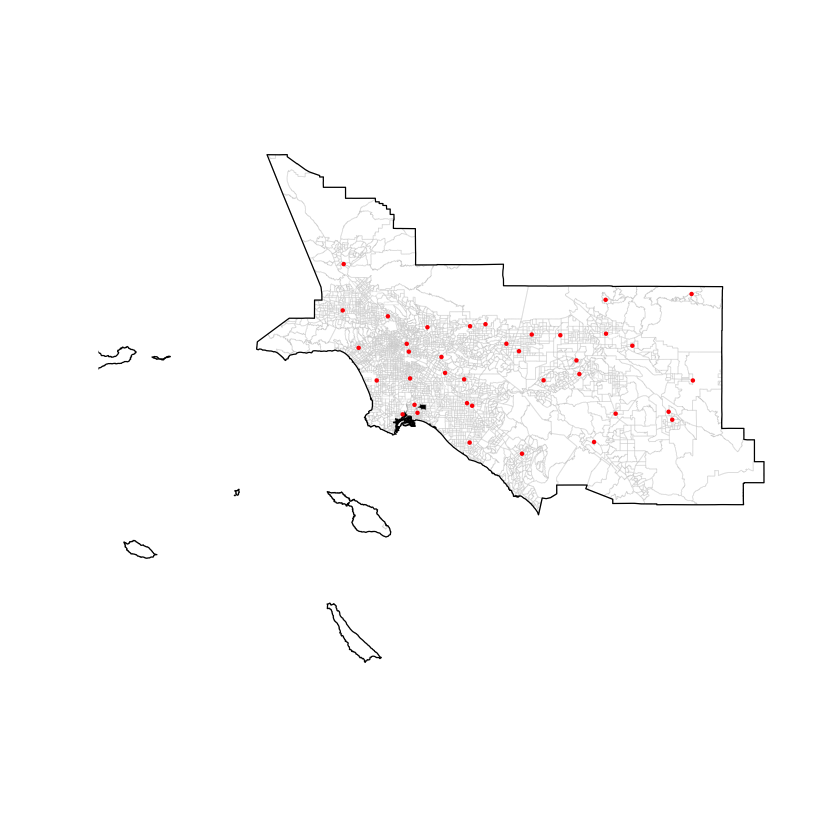

In [5]:
#map the south coast air basin with census tracts and monitoring station locations
par(mfrow=c(1,1))
plot(SC.tracts.t, border="lightgrey", lwd=0.3, col=SC.tracts.t$Diversity)
plot(SC.AirBasin.t, add=T)
plot(SC.monitor.t, add=T, col="red", cex=0.5, pch=16)

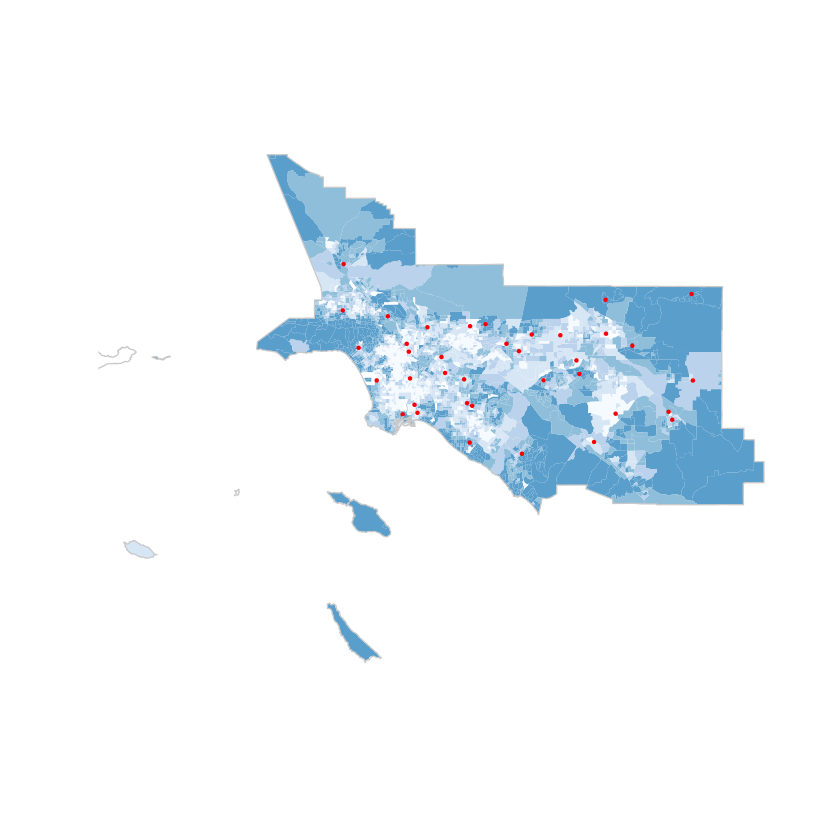

In [6]:
#choropleth map of diversity values
shades = auto.shading(as.numeric(SC.tracts.t$Diversity),cols=brewer.pal(9,"Blues"))
choropleth(SC.tracts.t,SC.tracts.t$Diversity,shading=shades, border=NA)
plot(SC.monitor.t, add=T, col="red", cex=0.5, pch=16)
plot(SC.AirBasin.t, add=T, border="lightgrey")

### Ozone Data

We can calculate some average ozone recordings for these sites 

In [7]:
#calculate mean and max ozone level for each site for all readings
mean.partmat <- aggregate(value ~ site, partmat, mean)
max.partmat <- aggregate(value ~ site, partmat, max)

#join the mean and max ozone values to their respective monitoring stations
#and rename the first col of monitoring data to site for merging purposes
names(SC.monitor.t)[1] <- "site"

#merge SC.monitor with ozone mean and max data
mrg.tab.mean <- sp::merge(SC.monitor.t, mean.partmat, by="site", all.x=FALSE)
mrg.tab.max <- sp::merge(SC.monitor.t, max.partmat, by="site", all.x=FALSE)

#create a max and a mean spatialPointDataFrame from data
partmat.mean.spdf = na.omit(mrg.tab.mean)
partmat.max.spdf = na.omit(mrg.tab.max)

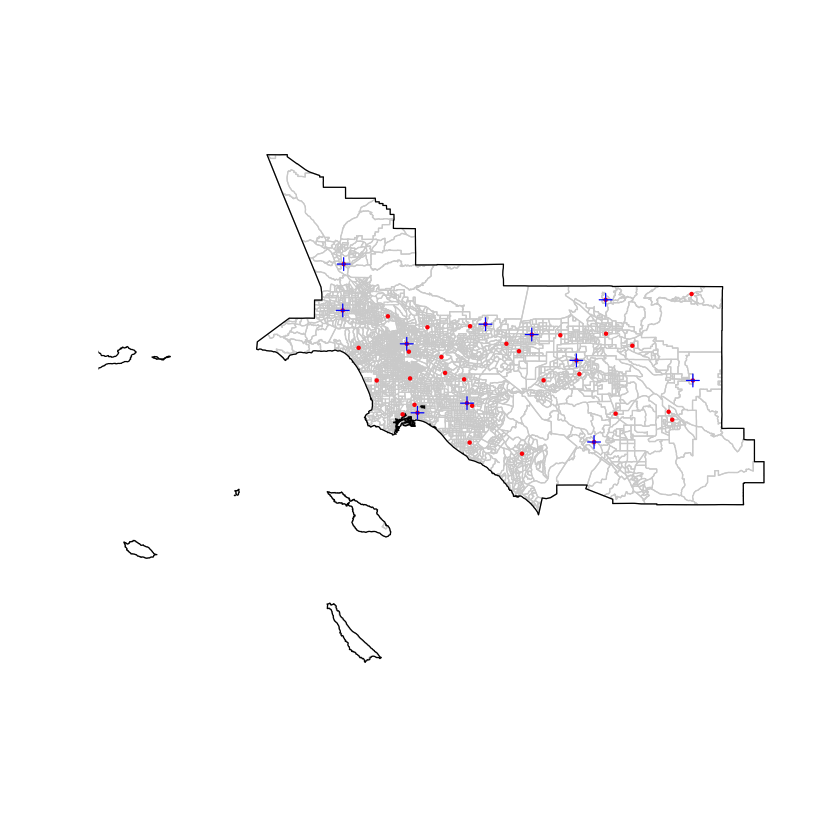

In [8]:
#add the merged moniotring stations to map in blue (there are less stations now as a result of merge)
par(mfrow=c(1,1))
plot(SC.tracts.t, border="lightgrey", col=SC.tracts.t$Diversity)
plot(SC.AirBasin.t, add=T)
plot(SC.monitor.t, add=T, col="red", cex=0.5, pch=16)
plot(partmat.mean.spdf,add=T,col="blue")

### Correlation and Regression Analysis

In [9]:
head(SC.tracts.t)

AFFGEOID             STATEFP COUNTYFP TRACTCE GEOID       NAME.1  LSAD
12 1400000US06037102105 06      037      102105  06037102105 1021.05 CT  
31 1400000US06037104500 06      037      104500  06037104500 1045    CT  
39 1400000US06037104822 06      037      104822  06037104822 1048.22 CT  
56 1400000US06037106642 06      037      106642  06037106642 1066.42 CT  
75 1400000US06037109601 06      037      109601  06037109601 1096.01 CT  
80 1400000US06037111100 06      037      111100  06037111100 1111    CT  
   ALAND   AWATER AREA        ⋯ CAABA_ID NAME.2      Total White Black AIndian
12 492761  0      18037550502 ⋯ 18       South Coast 1880  1249  37    5      
31 531002  0      18037550502 ⋯ 18       South Coast 2906  2311  0     0      
39 604352  0      18037550502 ⋯ 18       South Coast 2228  1533  5     23     
56 1577594 0      18037550502 ⋯ 18       South Coast 3323  2456  48    0      
75 2214559 33284  18037550502 ⋯ 18       South Coast 5285  3085  113   51     
80 1059245 0      18037550502 ⋯ 18       South Coast 3017  1670  222   0      
   Asian Hawaiian Diversity Income
12 131   0        0.6643617 46429 
31 5     0        0.7952512 49375 
39 156   0        0.6880610 42684 
56 290   0        0.7390912 82159 
75 771   0        0.5837275 73083 
80 464   0        0.5535300 72625

In [11]:
DV = as.numeric(SC.tracts.t$White)
INDV = as.numeric(SC.tracts.t$Black)

#plot(DV,INDV)

cor.test(DV,INDV)

#first, plot data and fit linear line through it based on least squares
#lmfit = lm(DV~INDV)
#abline(lmfit)

#conduct regression analysis
linear.model = lm(DV~INDV)
summary(linear.model)
resids = residuals(linear.model)


	Pearson's product-moment correlation

data:  DV and INDV
t = 0.81147, df = 3478, p-value = 0.4172
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01947720  0.04696343
sample estimates:
      cor 
0.0137583 



Call:
lm(formula = DV ~ INDV)

Residuals:
    Min      1Q  Median      3Q     Max 
-1807.6  -930.2  -167.5   798.0  2463.9 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.765e+03  3.587e+01  49.211   <2e-16 ***
INDV        4.170e-02  5.139e-02   0.811    0.417    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1131 on 3478 degrees of freedom
Multiple R-squared:  0.0001893,	Adjusted R-squared:  -9.818e-05 
F-statistic: 0.6585 on 1 and 3478 DF,  p-value: 0.4172


In [117]:
#prepare data for plotting residuals from the regression analysis

#first convert census tracts to a data frame object (need to not use spdf for now)
tracts.df = as.data.frame(SC.tracts.t)

#combine census data with residuals from census data
tracts.df = cbind(tracts.df[1],resids)

#change col header name
colnames(tracts.df)[2] = "residuals"

#merge the residuals data set with the census data set
SC.tracts.t = merge(SC.tracts.t, tracts.df, by='AFFGEOID')

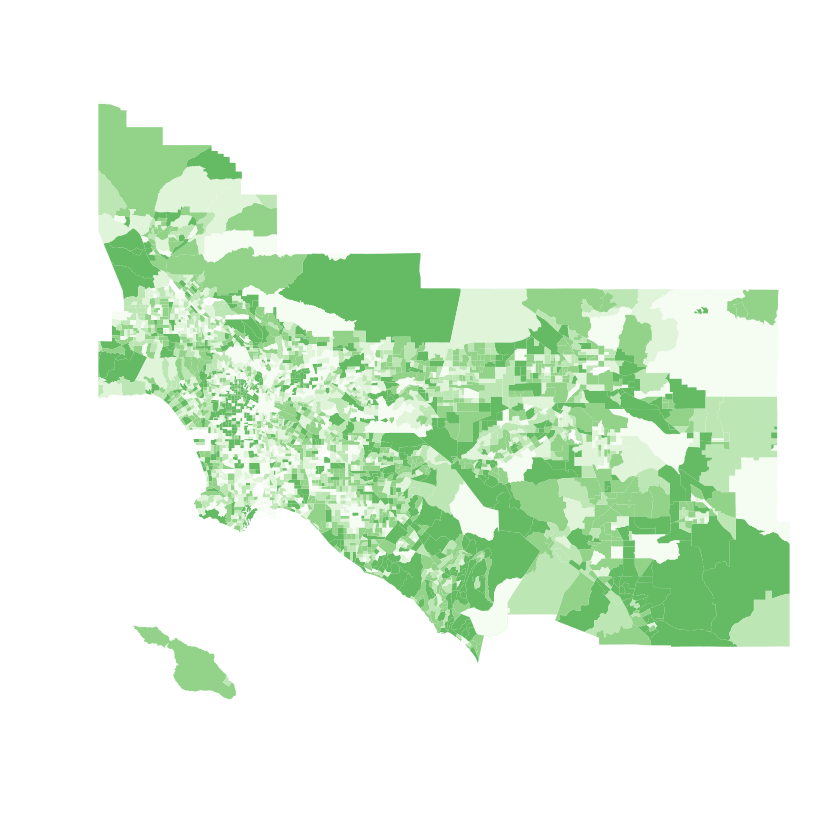

In [118]:
#set min and max lat/long for mapping residuals
minlat = min(SC.monitor$LATITUDE - 0.1)
maxlat = max(SC.monitor$LATITUDE + 0.1)
minlong = min(SC.monitor$LONGITUDE - 0.1)
maxlong = max(SC.monitor$LONGITUDE + 0.1)

#create a colouring scheme for choropleth map
shades = auto.shading(as.numeric(SC.tracts.t$residuals),cols=brewer.pal(9,"Greens"))

#create a choropleth map
choropleth(SC.tracts.t, SC.tracts.t$residuals, border=NA, shading=shades, xlim=c(minlong,maxlong), ylim=c(minlat,maxlat))

In [119]:
#conduct a global moran's i to see if residuals exhibit spatial autocorrelation

#create a weighted matrix file in order to perform moran's i analysis
SC.tracts.nb = poly2nb((SC.tracts.t), queen=FALSE)
SC.tracts.nb
#convert neighbour object to a listw object
SC.tract.lw = nb2listw(SC.tracts.nb, zero.policy = TRUE)
moran.test(resids,SC.tract.lw, zero.policy = TRUE)

Neighbour list object:
Number of regions: 3480 
Number of nonzero links: 18634 
Percentage nonzero weights: 0.1538678 
Average number of links: 5.354598 
2 regions with no links:
1607 2513


	Moran I test under randomisation

data:  resids  
weights: SC.tract.lw  

Moran I statistic standard deviate = 20.694, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.2188242372     -0.0002876043      0.0001121053 


In [120]:
#perform geographically weighted regression (only do this if results show spatial autocorrelation)

# (order of the dependent ~ independent terms is intentionally the opposite from the linear model)

gwr.res = gwr.basic(DV~INDV, data=SC.tracts.t, bw=20000, kernel='gaussian')

#note the gwr coefficeient estimates and the r squared value
gwr.res
head(gwr.res$SDF)

   ***********************************************************************
   *                       Package   GWmodel                             *
   ***********************************************************************
   Program starts at: 2018-01-16 18:43:58 
   Call:
   gwr.basic(formula = DV ~ INDV, data = SC.tracts.t, bw = 20000, 
    kernel = "gaussian")

   Dependent (y) variable:  DV
   Independent variables:  INDV
   Number of data points: 3480
   ***********************************************************************
   *                    Results of Global Regression                     *
   ***********************************************************************

   Call:
    lm(formula = formula, data = data)

   Residuals:
    Min      1Q  Median      3Q     Max 
-1807.6  -930.2  -167.5   798.0  2463.9 

   Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
   (Intercept) 1.765e+03  3.587e+01  49.211   <2e-16 ***
   INDV        4.170e-02  5.139e-

Intercept INDV       y    yhat     residual    CV_Score    Stud_residual
1 1765.02   0.04170142  213 1794.336 -1581.33583 -1581.83221 -1.39816940  
2 1765.02   0.04170142 1158 1765.061  -607.06144  -607.67087 -0.53693049  
3 1765.02   0.04170142  442 1800.716 -1358.71615 -1359.30555 -1.20140779  
4 1765.02   0.04170142 1290 1799.757  -509.75701  -509.96581 -0.45073332  
5 1765.02   0.04170142 1861 1768.356    92.64415    92.72053  0.08193406  
6 1765.02   0.04170142  566 1784.911 -1218.91131 -1219.29371 -1.07772448  
  Intercept_SE INDV_SE    Intercept_TV INDV_TV   Local_R2    
1 35.8665      0.05139017 49.21081     0.8114668 0.0001892909
2 35.8665      0.05139017 49.21081     0.8114668 0.0001892909
3 35.8665      0.05139017 49.21081     0.8114668 0.0001892909
4 35.8665      0.05139017 49.21081     0.8114668 0.0001892909
5 35.8665      0.05139017 49.21081     0.8114668 0.0001892909
6 35.8665      0.05139017 49.21081     0.8114668 0.0001892909

### Voronoi Tesselation

In [125]:
#prepare data
voronoipolygons = function(layer) {
	require(deldir)
	crds = layer@coords
	z = deldir(crds[,1], crds[,2])
	w = tile.list(z)
	polys = vector(mode='list', length=length(w))
	require(sp)
	for (i in seq(along=polys)) {
		pcrds = cbind(w[[i]]$x, w[[i]]$y)
		pcrds = rbind(pcrds, pcrds[1,])
		polys[[i]] = Polygons(list(Polygon(pcrds)), ID=as.character(i))
	}
	SP = SpatialPolygons(polys)
	voronoi = SpatialPolygonsDataFrame(SP, data=data.frame(dummy = seq(length(SP)), row.names=sapply(slot(SP, 'polygons'), function(x) slot(x, 'ID'))))
}

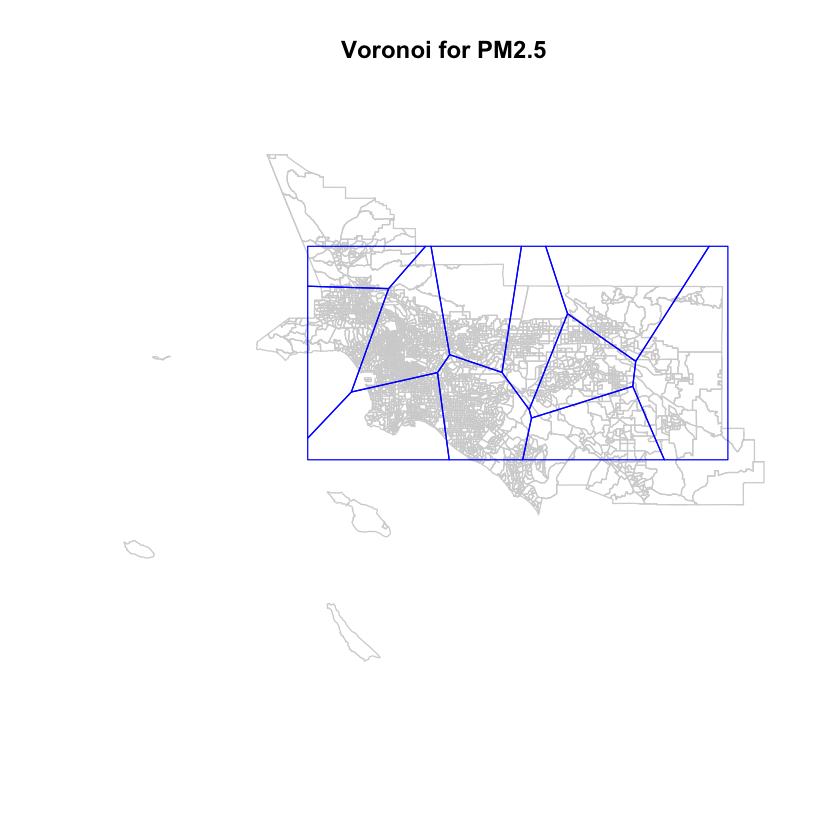

In [126]:
#calculate voronoi tesselation
partmat.voro = voronoipolygons(partmat.mean.spdf)
proj4string(partmat.voro) = proj4string((partmat.mean.spdf)) #define the projection

#plot voronoi polygons on top of census data as a visual check
plot(SC.tracts.t, main="Voronoi for PM2.5", border="lightgrey", col=NA)
plot(partmat.voro, , border="blue", col=NA, add=T)

In [127]:
#create points for calculating the interpolated surface
s.grid = spsample(partmat.voro, type="regular", n=6000)

#define the same projection
proj4string(s.grid) = proj4string(partmat.mean.spdf)

### Kriging

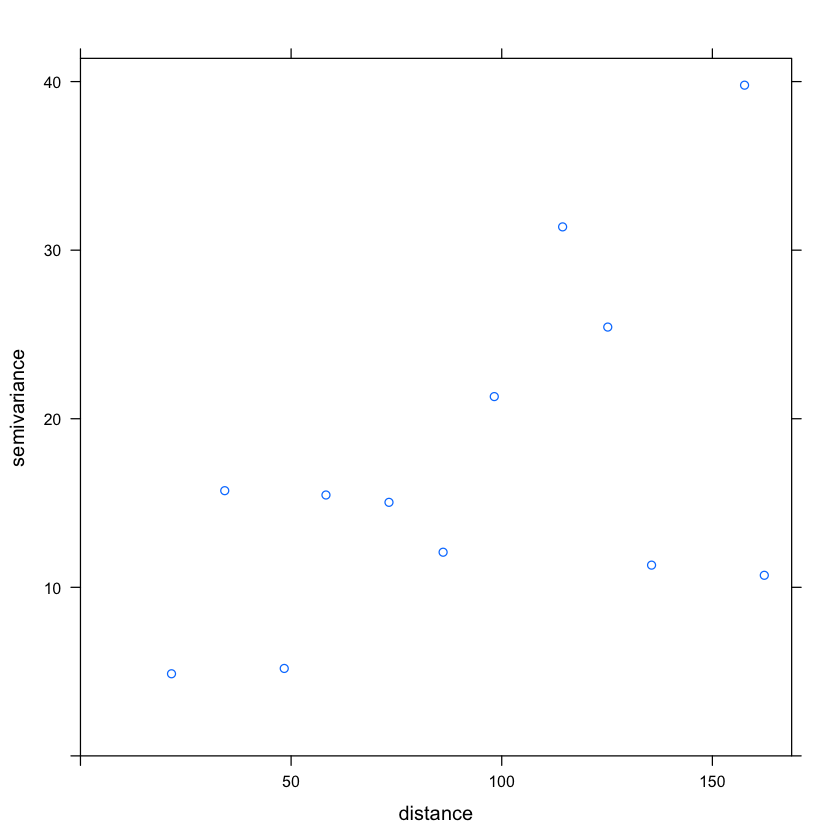

In [129]:
#for estimating semivariogram values
evgm <- variogram(value ~ 1, partmat.mean.spdf, boundaries=seq(0,200,l=16))
plot(evgm)

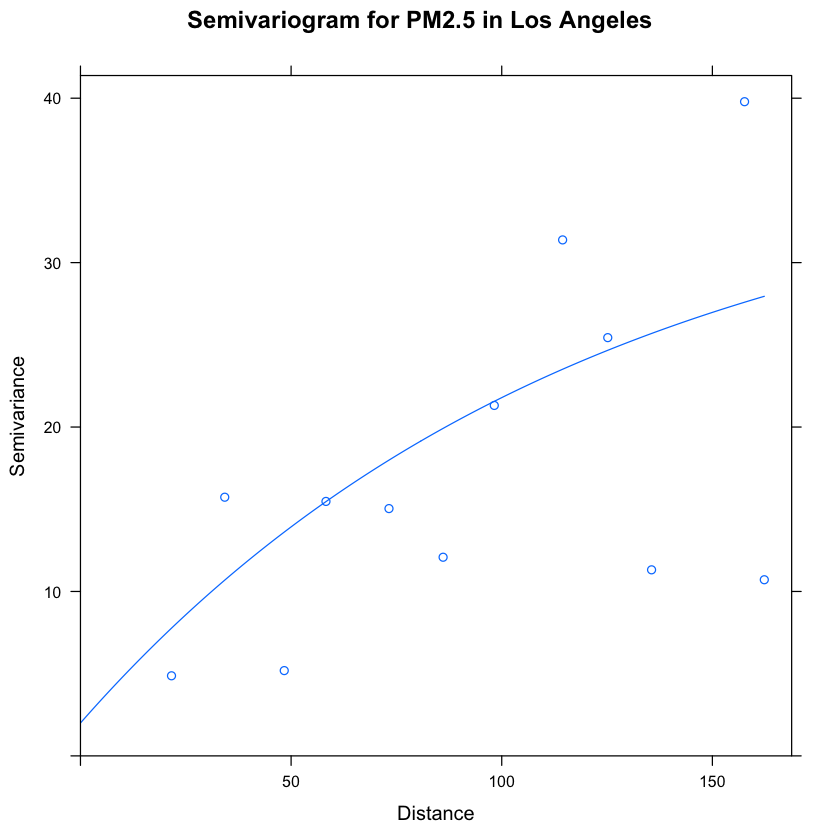

In [130]:
#estimated from graph
nugget = 2
sill = 35
range = 120
plot(evgm,model=vgm(sill,"Mat",range,nugget),main="Semivariogram for PM2.5 in Los Angeles", xlab="Distance", ylab="Semivariance")

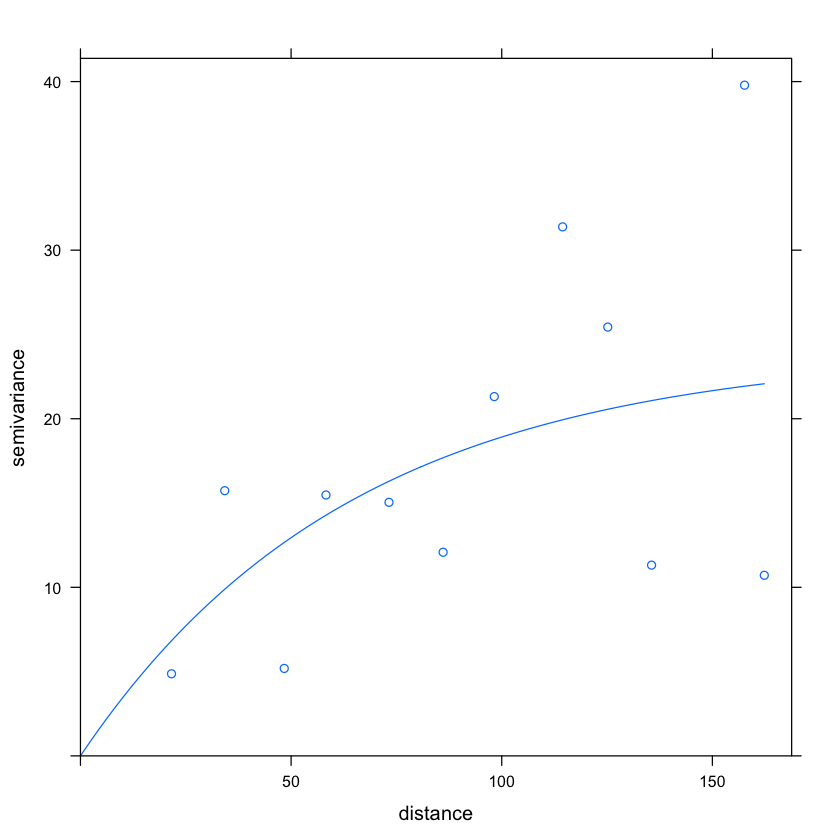

In [131]:
fvmg <- fit.variogram(evgm, vgm(1.4e-05, "Mat", 50, 0))
fvmg <- fit.variogram(evgm, vgm(27, "Mat", 50, 0))
plot(evgm, fvmg)

In [132]:
#perform kriging
krig.est <- krige(partmat.mean.spdf$value~1, partmat.mean.spdf, newdata=s.grid, model=fvmg)

#convert kriging surface to a raster dataset
r = raster(extent(krig.est), ncols=115, nrows=52, crs=proj4string(krig.est))

# dim(krig.est) #"+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0"
krig.rst = rasterize(krig.est, r, "var1.pred")

[using ordinary kriging]


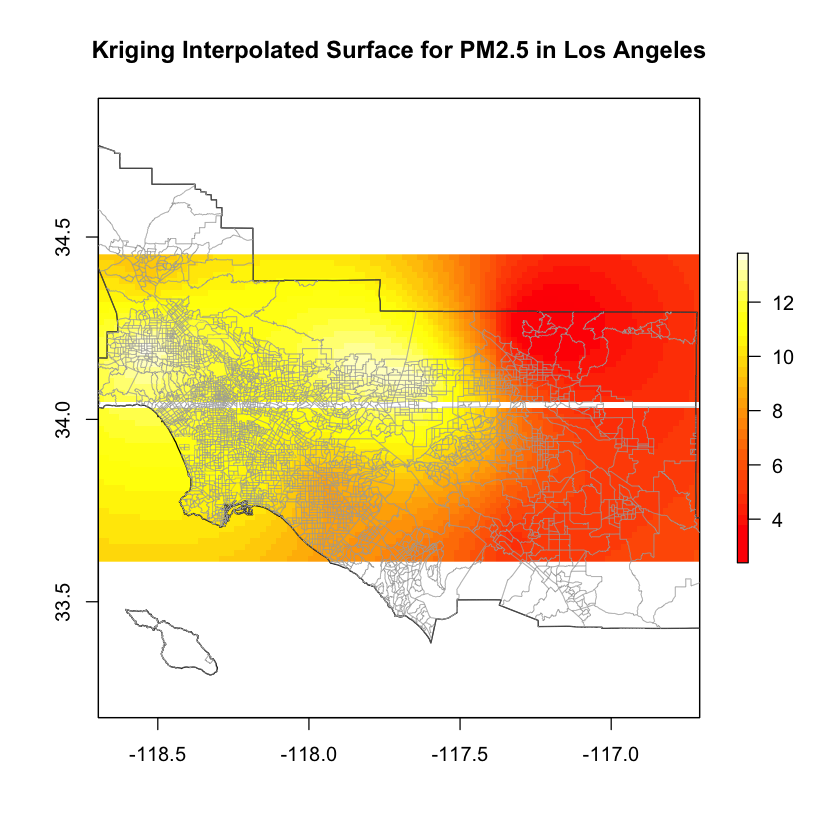

In [133]:
#plot raster interpolated surface with census tracts
plot(krig.rst, col=heat.colors(30, alpha=1),main="Kriging Interpolated Surface for PM2.5 in Los Angeles")
plot(SC.AirBasin.t, add=T)
plot(SC.tracts.t, main="Kriging", border="darkgrey", col=NA, add=T, lwd=0.4)
# plot(centroid.spdf, col="black", pch=16, cex=0.4, add=T) #do after centroids

### Joining Pollution and Census Data

Now that we have our interpolated surface of PM2.5 levels across LA we can extract numeric values from the raster and merge them with the census data.

In [134]:
#calculate centroids of census tracts polygons
centroid <- centroid(SC.tracts.t)
centroid.spdf <- as.data.frame(centroid)
coordinates(centroid.spdf) <- ~ V1 + V2

In [135]:
#extract numeric values from kriging raster
partmat.krig.c = raster::extract(krig.rst, centroid.spdf)

#convert numeric values to data.frame
partmat.krig.c.as.df = as.data.frame(partmat.krig.c)

#add data frame to SpatialPoints 
#this allows us to convert SpatialPoints (centroid.spdf) to SPDF
partmat.c.spdf = SpatialPointsDataFrame(centroid.spdf, partmat.krig.c.as.df)

In [136]:
#merge data extracted from kriging raster with census data
census.pt = raster::intersect(partmat.c.spdf, SC.tracts.t) 
# (using ozone.spdf instead of centroid scpd to assure spatial overlap between both datasets)
dim(census.pt)

[1] 3477   24

In [140]:
#keep only informaion about diversity and pollution
fin.tab = data.frame(census.pt@data$partmat.krig.c, census.pt@data$Diversity)

#change names of columns to readable format
names(fin.tab) = c("mean.partmat", "div")

#check names and table
head(fin.tab)

mean.partmat div      
1 11.97879     0.6643617
2 12.18038     0.7952512
3 12.18038     0.6880610
4 11.86496     0.7390912
5 12.02069     0.5837275
6 12.21087     0.5535300

Now that data is ready to perform correlation and regression analysis on the pollution and diversity levels (as previously it was just race).

### Descriptive Statistics
Some descriptive statistics are calculated, as these will be useful for the resulting paper.

In [141]:
all.data = read.csv("data/SCtracts-t.csv", header=T, sep=",")

partmat = read.csv("data/PM25HR_PICKDATA_2016-4-30.csv", header=T, sep=",")
head(partmat)
mean.partmat <- aggregate(value ~ site, partmat, mean)
max.partmat <- aggregate(value ~ site, partmat, max)

#mean of mean PM2.5 across whole of LA
mean(mean.partmat$value)
#same of max
mean(max.partmat$value)

median(mean.partmat$value)
names(sort(-table(mean.partmat$value)))[1] #mode
sd(mean.partmat$value)
skewness(mean.partmat$value)
kurtosis(mean.partmat$value)
sd(mean.partmat$value)/mean(mean.partmat$value) #coefficient of variation
min(mean.partmat$value)
max(mean.partmat$value)

site monitor date       start_hour value variable
1 2849 -       2016-04-30 0          22    PM25HR  
2 2849 -       2016-04-30 1          14    PM25HR  
3 2849 -       2016-04-30 2          11    PM25HR  
4 2849 -       2016-04-30 3           9    PM25HR  
5 2849 -       2016-04-30 4          11    PM25HR  
6 2849 -       2016-04-30 5          11    PM25HR  
  units                                       quality prelim name            
1 Micrograms/Cubic Meter ( ug/m<sup>3</sup> ) 0       y      Glendora-Laurel 
2 Micrograms/Cubic Meter ( ug/m<sup>3</sup> ) 0       y      Glendora-Laurel 
3 Micrograms/Cubic Meter ( ug/m<sup>3</sup> ) 0       y      Glendora-Laurel 
4 Micrograms/Cubic Meter ( ug/m<sup>3</sup> ) 0       y      Glendora-Laurel 
5 Micrograms/Cubic Meter ( ug/m<sup>3</sup> ) 0       y      Glendora-Laurel 
6 Micrograms/Cubic Meter ( ug/m<sup>3</sup> ) 0       y      Glendora-Laurel

ERROR: Error in get(as.character(FUN), mode = "function", envir = envir): object 'FUN' of mode 'function' was not found


In [154]:
race.data = read.csv("data/race-edit.csv") #edited race data
head(race.data)
paste("Mean:", mean(race.data$Diversity))
paste("Median:", median(race.data$Diversity))
paste("Mode:", names(sort(-table(race.data$Diversity)))[1])
paste("Standard dev:", sd(race.data$Diversity))
paste("Skewness:", skewness(race.data$Diversity))
paste("Kurtosis:", kurtosis(race.data$Diversity))
paste("Coef of variation:", sd(race.data$Diversity)/mean(race.data$Diversity))
paste("Min:", min(race.data$Diversity))
paste("Max:", max(race.data$Diversity))

AFFGEOID             Total White Black AIndian Asian Hawaiian Max  Diversity
1 1400000US06001400100 3385  2235  137    0      722   0        2235 0.6602659
2 1400000US06001400200 1939  1487   34    0      220   0        1487 0.7668902
3 1400000US06001400300 5428  3599  715   13      683   0        3599 0.6630435
4 1400000US06001400400 4279  2988  715   17      347   0        2988 0.6982940
5 1400000US06001400500 3516  2238  902    8      115   0        2238 0.6365188
6 1400000US06001400600 1750   683  638   15       85   0         683 0.3902857

[1] "Mean: 0.654145057172409"

[1] "Median: 0.6710164665"

[1] "Mode: 1"

[1] "Standard dev: 0.173080659308116"

[1] "Skewness: -0.328319148740444"

[1] "Kurtosis: 2.28061694807561"

[1] "Coef of variation: 0.264590639966416"

[1] "Min: 0.128712871"

[1] "Max: 1"

In [157]:
##using all.data##

#pm2.5 values
paste("Mean:", mean(all.data$mean.partmat))
paste("Median:", median(all.data$mean.partmat))
paste("Mode:", names(sort(-table(all.data$mean.partmat)))[1])
paste("Standard dev:", sd(all.data$mean.partmat))
paste("Skewness:", skewness(all.data$mean.partmat))
paste("Kurtosis:", kurtosis(all.data$mean.partmat))
paste("Coef of variation:", sd(all.data$mean.partmat)/mean(all.data$mean.partmat))
paste("Min:", min(all.data$mean.partmat))
paste("Max:", max(all.data$mean.partmat))

[1] "Mean: 10.5125376124622"

[1] "Median: 11.21313086"

[1] "Mode: 11.66151813"

[1] "Standard dev: 2.17469753042053"

[1] "Skewness: -1.2374788383933"

[1] "Kurtosis: 4.08520493952207"

[1] "Coef of variation: 0.206867039204932"

[1] "Min: 2.405510774"

[1] "Max: 13.79590657"

In [158]:
#diversity values
mean(all.data$Diversity)
median(all.data$Diversity)
names(sort(-table(all.data$Diversity)))[1] #mode
sd(all.data$Diversity)
skewness(all.data$Diversity)
kurtosis(all.data$Diversity)
sd(all.data$Diversity)/mean(all.data$Diversity) #coefficient of variation
min(all.data$Diversity)
max(all.data$Diversity)

[1] 0.3985618

[1] 0.3897947

[1] "0.333333333"

[1] 0.1630712

[1] 0.201862

[1] 2.356014

[1] 0.4091491

[1] 0

[1] 0.8666391

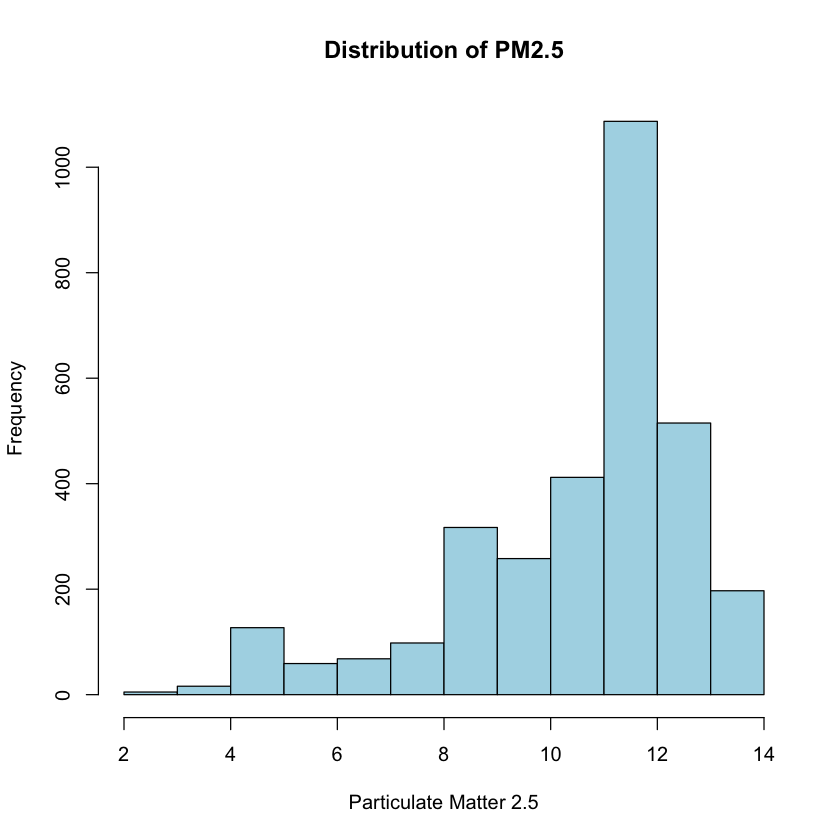

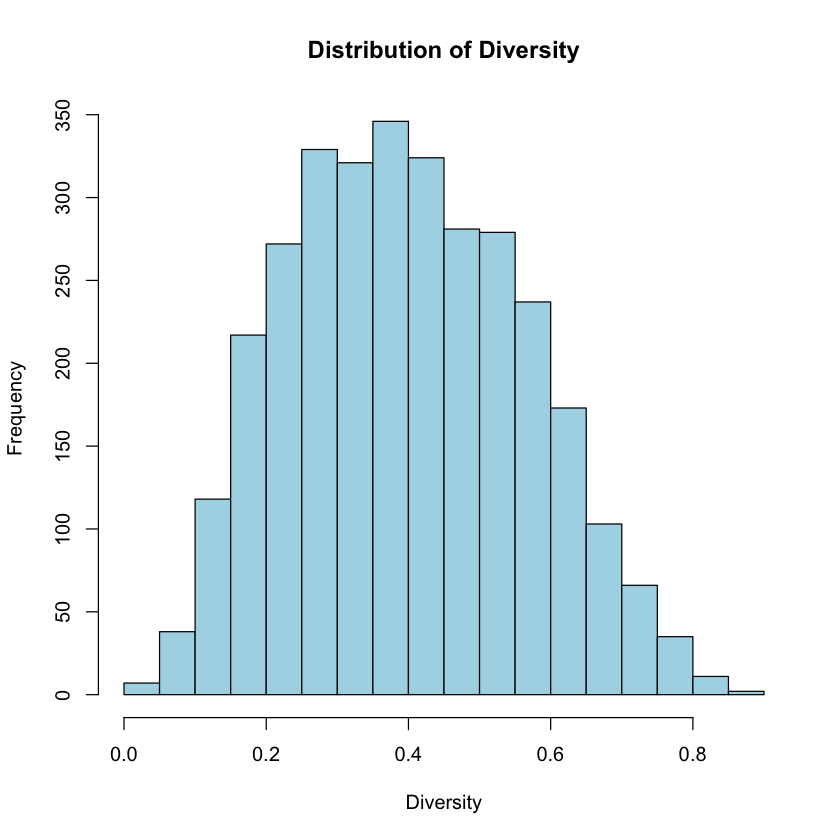

In [159]:
#histograms
hist(all.data$mean.partmat, main="Distribution of PM2.5", xlab="Particulate Matter 2.5", ylab="Frequency", col="lightblue")
hist(all.data$Diversity, main="Distribution of Diversity", xlab="Diversity", ylab="Frequency", col="lightblue")

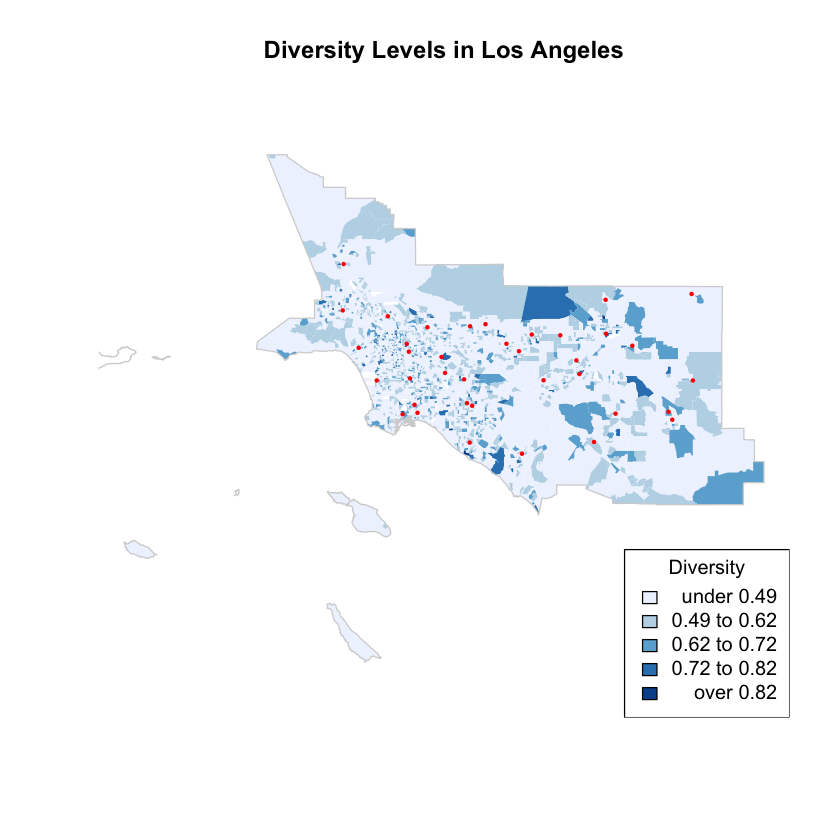

In [163]:
#choropleth map of diversity values
shades = auto.shading(as.numeric(race.data$Diversity),cols=brewer.pal(5,"Blues"))
choropleth(SC.tracts.t,all.data$Diversity,shading=shades, border=NA, main="Diversity Levels in Los Angeles")
choro.legend(px="bottomright", sh=shades, bg="white", title="Diversity")
plot(SC.monitor.t, add=T, col="red", cex=0.5, pch=16)
plot(SC.AirBasin.t, add=T, border="lightgrey")

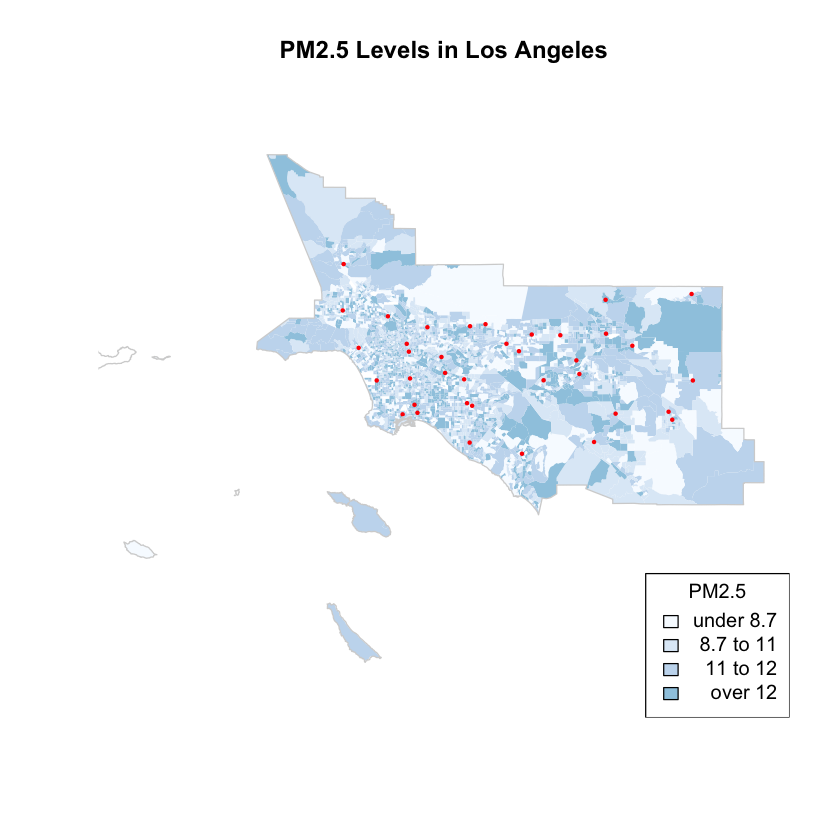

In [65]:
#choropleth map of particulate matter values
shades2 = auto.shading(as.numeric(all.data$mean.partmat),cols=brewer.pal(9,"Blues"))
choropleth(SC.tracts.t,all.data$mean.partmat,shading=shades2,border=NA, main="PM2.5 Levels in Los Angeles")
choro.legend(px="bottomright",sh=shades2,bg="white", title="PM2.5")
plot(SC.monitor.t, add=T, col="red", cex=0.5, pch=16)
plot(SC.AirBasin.t, add=T, border="lightgrey")

## Spatial Descriptive and Spatial Inferential Measures

In [164]:
#read EPA monitoring shapefile data
monitor <- readOGR(dsn="data/airmonitoringstations.shp", layer="airmonitoringstations")

#extract monitoring station points within the South coast
SC.monitor = monitor[monitor$AIRBASIN %in% c("South Coast"),]

#reproject the data to a suitable projection
#utm used because of the scale of the analysis
SC.monitor.t = spTransform(SC.monitor, CRS("+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 + towgs84=0,0,0"))

OGR data source with driver: ESRI Shapefile 
Source: "data/airmonitoringstations.shp", layer: "airmonitoringstations"
with 296 features
It has 12 fields


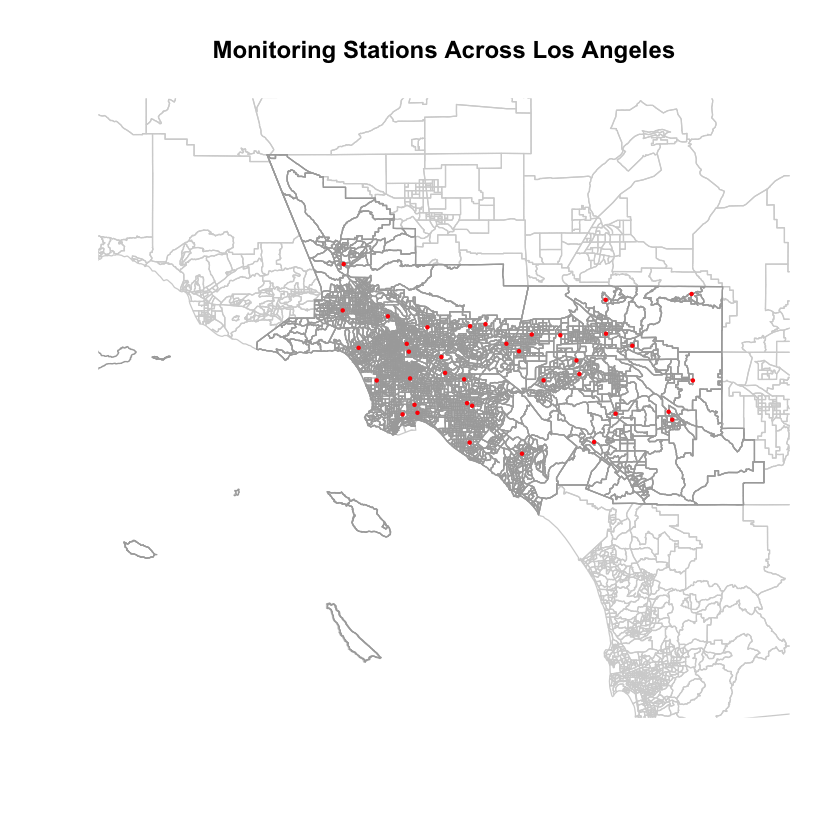

In [165]:
plot(SC.tracts.t, border="darkgrey", main="Monitoring Stations Across Los Angeles")
plot(all.tracts.t, border="lightgrey", add=T)
plot(SC.tracts.t,border="darkgrey", add=T)
plot(SC.AirBasin.t,border="darkgrey", add=T)
plot(SC.monitor.t,add=T,col="red",cex=0.5,pch=16)

In [166]:
#mean centre (** weighted mean centre not neccessary because there is only 1 entry per location **)
meanlat = mean(SC.monitor.t$LATITUDE)
meanlong = mean(SC.monitor.t$LONGITUDE)
meancentre = c(meanlat,meanlong)

#standard distance
tempdata = as.data.frame(SC.monitor.t)
tempdata = cbind(tempdata, xmean=tempdata$LATITUDE-meanlat)
tempdata = cbind(tempdata, ymean=tempdata$LONGITUDE-meanlong)
sumX = sum((tempdata$xmean)**2)
sumY = sum((tempdata$ymean)**2)
standdist = sqrt((sumX+sumY)/length(tempdata$LATITUDE))

#relative distance
longdist = max(tempdata$LONGITUDE) - min(tempdata$LONGITUDE)
latdist = max(tempdata$LATITUDE) - min(tempdata$LATITUDE)
sqarea = longdist*latdist
circleradius = sqrt(sqarea/pi)
reldist = standdist/circleradius

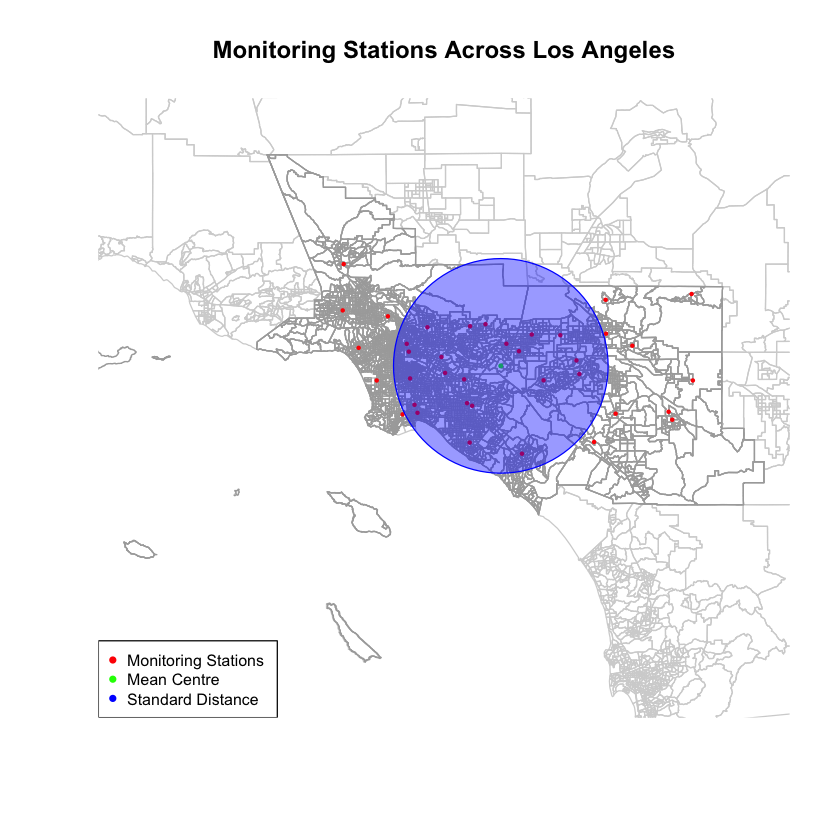

In [167]:
#map for displaying new values
#plot(meancentre,add=T,col="blue",cex=0.5,pch=16)
plot(SC.tracts.t, border="darkgrey", main="Monitoring Stations Across Los Angeles")
plot(all.tracts.t, border="lightgrey", add=T)
plot(SC.tracts.t,border="darkgrey", add=T)
plot(SC.AirBasin.t,border="darkgrey", add=T)
plot(SC.monitor.t,add=T,col="red",cex=0.5,pch=16)
draw.circle(-117.7768,33.9788,0.009,col="green",border="green")
draw.circle(-117.7768,33.9788,standdist,col=rgb(0,0,1,0.4),border="blue")
legend(x="bottomleft",legend=c("Monitoring Stations","Mean Centre","Standard Distance"),col=c("red","green","blue"),bg="white",pch=16,border="white",cex=0.8)

### Quadrat Analysis

In [168]:
#create a window (boundary) object to define study site
window = as.owin(SC.tracts.t)
#prepare data for point pattern analysis
monitors.ppp = ppp(x=tempdata$LONGITUDE,y=tempdata$LATITUDE,window=window)
#define number of quadrats used in analysis
quads = 8
#use fxn quadratcount to calc number of points per quadrats
qcount = quadratcount(monitors.ppp,nx=quads,ny=quads)

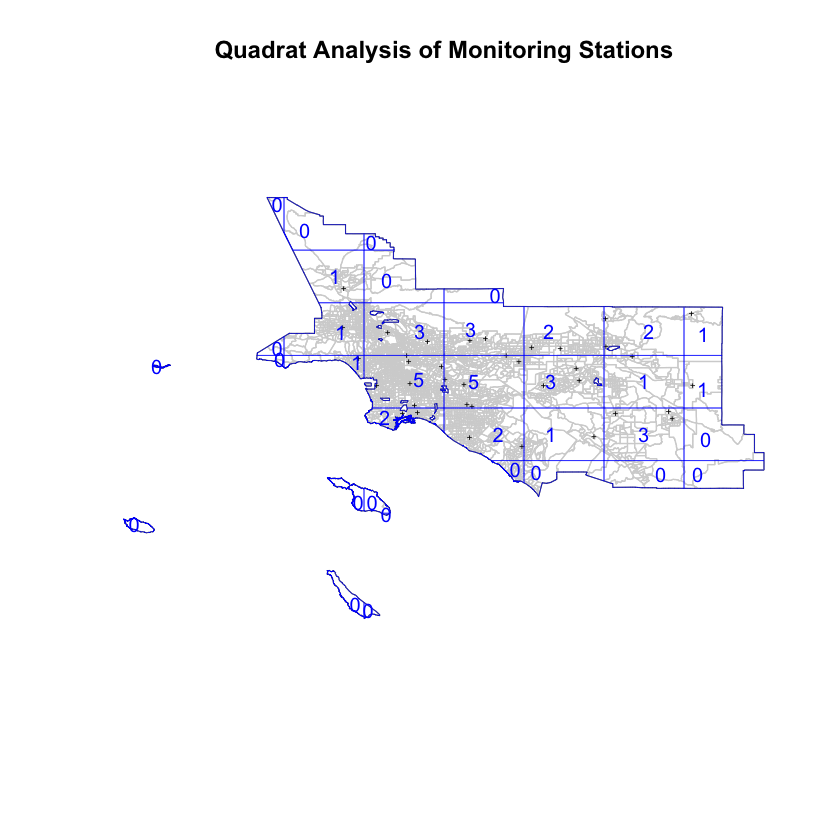

In [169]:
#create map showing quadrats and points per quadrats
# jpeg("Quadrat16.jpeg",2500,2000,res=300) # only to save
plot(monitors.ppp,pch="+",cex=0.5,border="lightgrey",main="Quadrat Analysis of Monitoring Stations")
plot(qcount,add=T,col="blue",lwd=0.5)

In [171]:
#now prepare data to be able to calculate the variables for a quadrat analysis

#first deifne the quadrat count dataset as a dataframe
qcount.df = as.data.frame((qcount))

#count the number of quadrats with distinct number of points
qcount.df = count(qcount.df,'Freq')

#change column names
colnames(qcount.df) = c("x","f")

#create new columns for total number of points and for fx^2
qcount.df = cbind(qcount.df, totalpoints = as.numeric(qcount.df$x)*as.numeric(qcount.df$f))
qcount.df = cbind(qcount.df, fx2 = (as.numeric(qcount.df$x)^2)*as.numeric(qcount.df$f))

#calculate the sum of each column to use as inputs into the formula for vmr
f.sum = sum(qcount.df$f)
totalpoints.sum = sum(qcount.df$totalpoints)
fx2.sum = sum(qcount.df$fx2)

In [173]:
#calculate variance, mean, vmr
variance = (fx2.sum * (totalpoints.sum**2 / quads**2)) / (quads**2 -1) 
mean = totalpoints.sum / f.sum
vmr = variance/mean
vmr

[1] 36.00893

In [86]:
#calc the chi^2 statistic to test for existence of a random spatial pattern
chisquare = chisq.test(qcount.df)
chisquare

Warning message in chisq.test(qcount.df):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  qcount.df
X-squared = 109.13, df = 12, p-value < 2.2e-16


In [174]:
#nearest neighbour analysis
nearestNeighbour = nndist(monitors.ppp)
nearestNeighbour = as.data.frame(as.numeric(nearestNeighbour))
colnames(nearestNeighbour) = "Distance"
nnd = sum(nearestNeighbour$Distance)/length(nearestNeighbour$Distance)
nnd

[1] 0.107696

### Spatial autocorrelation

In [181]:
#lagged mean plots
#neighbour lists extracted
SC.tracts.nb = poly2nb((SC.tracts.t), queen=FALSE)
#convert to a listw object
SC.tracts.lw = nb2listw(SC.tracts.nb, zero.policy=TRUE)
diversity.lagged.means <- lag.listw(SC.tracts.lw,all.data$Diversity)
choropleth(SC.tracts.t,smk.lagged.means,shades)

ERROR: Error in lag.listw(SC.tracts.lw, race.data$Diversity): object lengths differ


ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [1] not equal to array extent


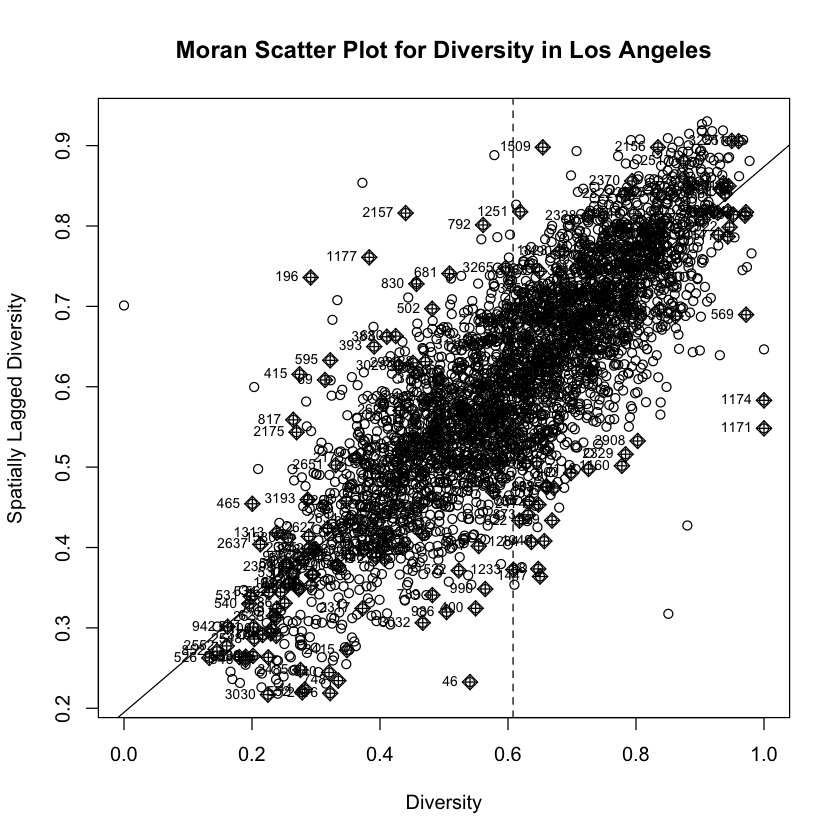

In [178]:
moran.plot(SC.tracts.t$Diversity,SC.tracts.lw,xlab="Diversity",ylab="Spatially Lagged Diversity",main="Moran Scatter Plot for Diversity in Los Angeles")

In [185]:
#global
#z - (global i - expectation) / sqrt(variance) = moran i stat stand dev
moran.test(SC.tracts.t$Diversity,SC.tracts.lw,zero.policy=TRUE)


	Moran I test under randomisation

data:  SC.tracts.t$Diversity  
weights: SC.tracts.lw  

Moran I statistic standard deviate = 64.101, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.6783999547     -0.0002876043      0.0001121008 


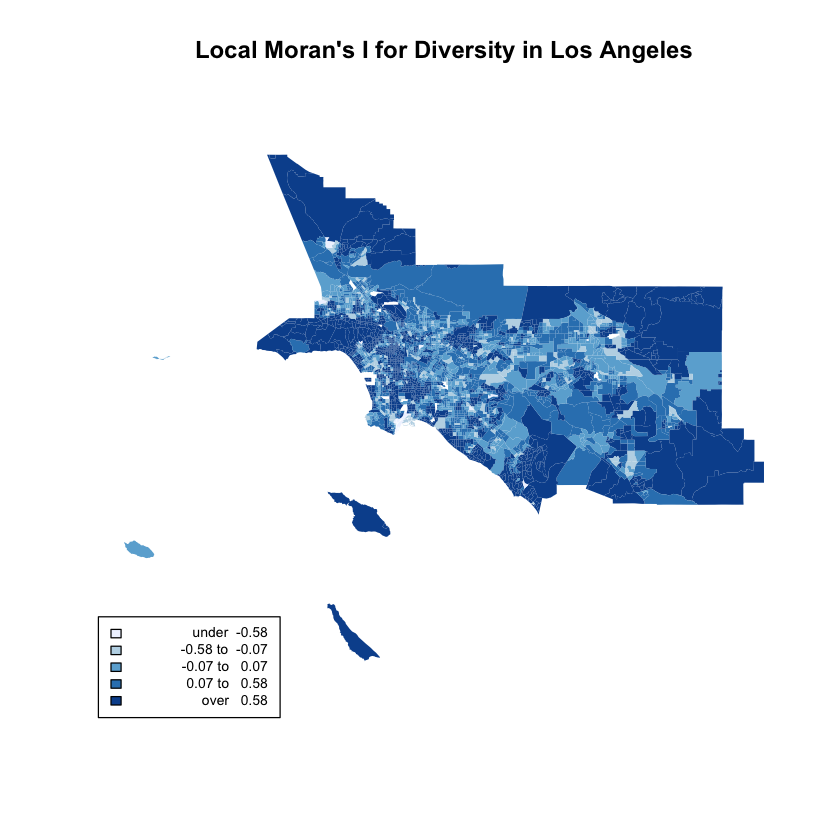

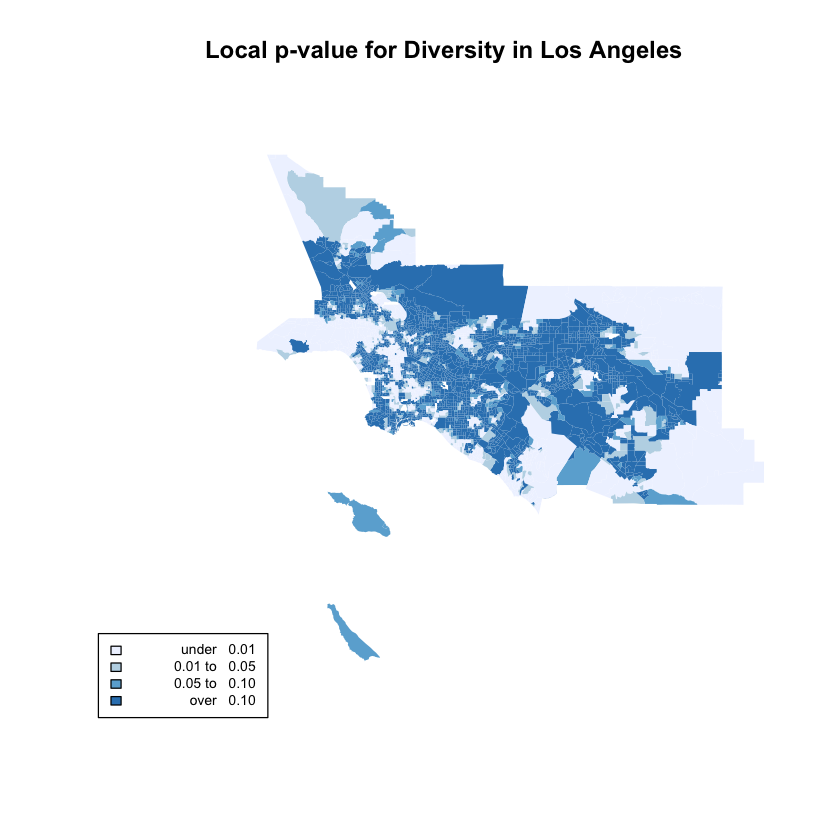

In [186]:
#local morans i
div.lI <- localmoran(SC.tracts.t$Diversity,SC.tracts.lw, zero.policy=TRUE)
#create shading scheme
div.shades <- auto.shading(c(div.lI[,1],-div.lI[,1]),cols=brewer.pal(5,"Blues"))
choropleth(SC.tracts.t,div.lI[,1],shading=div.shades,border=NA,main="Local Moran's I for Diversity in Los Angeles")
choro.legend("bottomleft",sh=div.shades,fmt="%6.2f",xpd=TRUE,cex=0.7)
#for p value
pval.shades <- shading(c(0.01,0.05,0.1),cols=brewer.pal(5,"Blues"))
choropleth(SC.tracts.t,div.lI[,5],shading=pval.shades,border=NA,main="Local p-value for Diversity in Los Angeles")
choro.legend("bottomleft",sh=pval.shades,fmt="%6.2f",xpd=TRUE,cex=0.7)

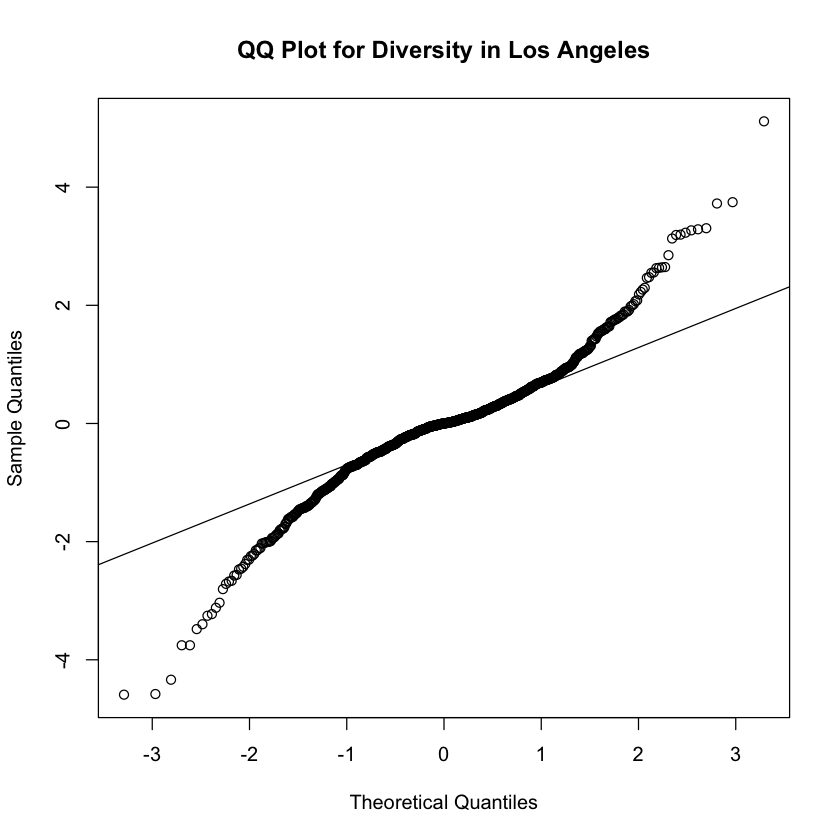

In [187]:
#test for normality
#matrix of simulated local morans i
sim.I <- matrix(0,1000,length(SC.tracts.t$Diversity))
#evaluate simulated distribution
for(i in 1:1000) sim.I[i,] <- localmoran(sample(SC.tracts.t$Diversity),SC.tracts.lw)[,4]
qqnorm(sim.I[,1],main="QQ Plot for Diversity in Los Angeles")
qqline(sim.I[,1])

### Spatial Interpolation

To create a pollution surface from monitoring station data, we use Voronoi tesselation and then Kriging, as there are not enough monitoring stations for all census tracts to be represented.


	Pearson's product-moment correlation

data:  IV and DV
t = 7.1077, df = 3157, p-value = 1.453e-12
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09102432 0.15967535
sample estimates:
      cor 
0.1255001 



Call:
lm(formula = DV ~ IV)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40044 -0.12806 -0.00852  0.12213  0.45934 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.299631   0.014213  21.081  < 2e-16 ***
IV          0.009411   0.001324   7.108 1.45e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1618 on 3157 degrees of freedom
Multiple R-squared:  0.01575,	Adjusted R-squared:  0.01544 
F-statistic: 50.52 on 1 and 3157 DF,  p-value: 1.453e-12


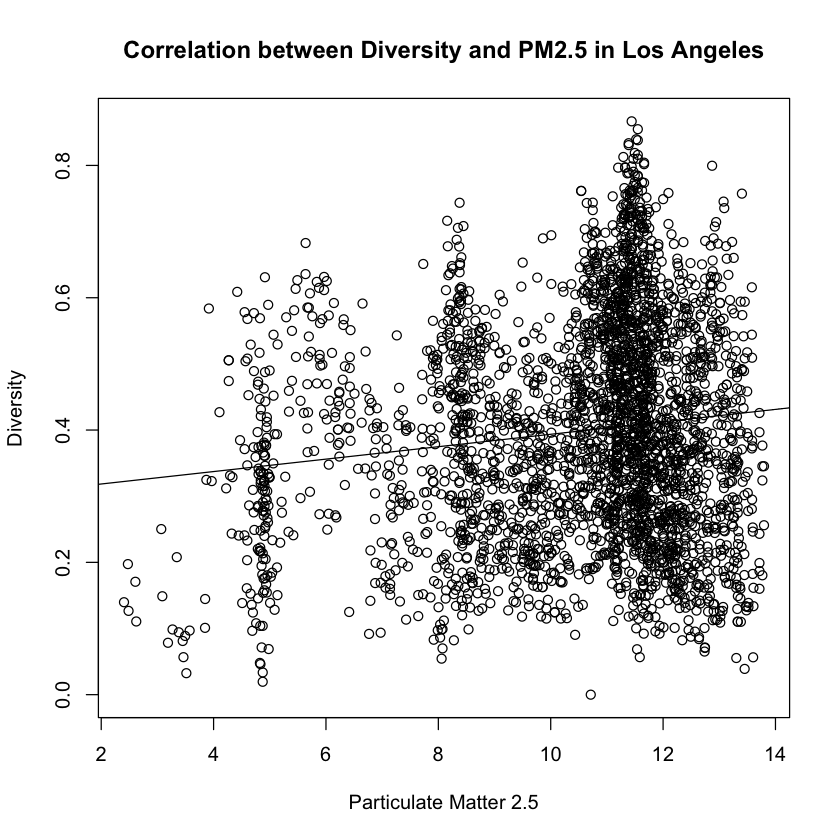

In [184]:
# correlation analysis
IV = all.data$mean.partmat
DV = all.data$Diversity
plot(IV,DV, main="Correlation between Diversity and PM2.5 in Los Angeles", xlab="Particulate Matter 2.5", ylab="Diversity")
cor.test(IV,DV)

# regression analysis
lmfit = lm(DV~IV)
abline(lmfit)
linear.model = lm(DV~IV)
summary(linear.model)
resids = residuals(linear.model)

In [101]:
write.csv(SC.tracts.t,file="for-resids.csv")
for.resids = read.csv("for-resids.csv", header=T, sep=",")

In [204]:
tracts.df = as.data.frame(for.resids)
tracts.df = merge(tracts.df[1],resids) #used to be cbind
colnames(tracts.df)[2] = "residuals"
merge.tracts = merge(for.resids,tracts.df,by='X')

In [3]:
minlat = min(SC.monitor$LATITUDE - 0.1)
maxlat = max(SC.monitor$LATITUDE + 0.1)
minlong = min(SC.monitor$LONGITUDE - 0.1)
maxlong = max(SC.monitor$LONGITUDE + 0.1)

ERROR: Error in eval(expr, envir, enclos): object 'SC.monitor' not found


In [ ]:
shades = auto.shading(as.numeric(merge.tracts$residuals),cols=brewer.pal(9,"Blues"))
choropleth(merge.tracts, merge.tracts$residuals, border=NA, shading=shades, xlim=c(minlong,maxlong), ylim=c(minlat,maxlat))

In [104]:
#global moran's i to see if residuals exhibit spatial autocorrelation
#weighted matrix created to perform moran's i analysis
SC.tracts.nb = poly2nb((merge.tracts), queen=FALSE)
SC.tracts.nb
#convert neighbour object to a listw object
SC.tract.lw = nb2listw(SC.tracts.nb, zero.policy = TRUE)
moran.test(resids,SC.tract.lw, zero.policy = TRUE)

ERROR: Error in extends(class(pl), "SpatialPolygons"): object 'merge.tracts' not found


In [105]:
all.df = as.data.frame(all.data)
all.spdf = SpatialPointsDataFrame(all.data,all.df)
#perform geographically weighted regression (only if spatially autocorrelated)
gwr.res = gwr.basic(as.numeric(DV)~as.numeric(IV), data=SC.tracts.t, bw=20000, kernel='gaussian')

ERROR: Error in .local(obj, ...): cannot derive coordinates from non-numeric matrix


In [106]:
#note the gwr coefficeient estimates and the r squared value
gwr.res
head(gwr.res$SDF)

   ***********************************************************************
   *                       Package   GWmodel                             *
   ***********************************************************************
   Program starts at: 2018-01-16 16:47:35 
   Call:
   gwr.basic(formula = DV ~ INDV, data = SC.tracts.t, bw = 20000, 
    kernel = "gaussian")

   Dependent (y) variable:  DV
   Independent variables:  INDV
   Number of data points: 3480
   ***********************************************************************
   *                    Results of Global Regression                     *
   ***********************************************************************

   Call:
    lm(formula = formula, data = data)

   Residuals:
    Min      1Q  Median      3Q     Max 
-1807.6  -930.2  -167.5   798.0  2463.9 

   Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
   (Intercept) 1.765e+03  3.587e+01  49.211   <2e-16 ***
   INDV        4.170e-02  5.139e-

Intercept INDV       y    yhat     residual    CV_Score    Stud_residual
1 1765.02   0.04170142  213 1794.336 -1581.33583 -1581.83221 -1.39816940  
2 1765.02   0.04170142 1158 1765.061  -607.06144  -607.67087 -0.53693049  
3 1765.02   0.04170142  442 1800.716 -1358.71615 -1359.30555 -1.20140779  
4 1765.02   0.04170142 1290 1799.757  -509.75701  -509.96581 -0.45073332  
5 1765.02   0.04170142 1861 1768.356    92.64415    92.72053  0.08193406  
6 1765.02   0.04170142  566 1784.911 -1218.91131 -1219.29371 -1.07772448  
  Intercept_SE INDV_SE    Intercept_TV INDV_TV   Local_R2    
1 35.8665      0.05139017 49.21081     0.8114668 0.0001892909
2 35.8665      0.05139017 49.21081     0.8114668 0.0001892909
3 35.8665      0.05139017 49.21081     0.8114668 0.0001892909
4 35.8665      0.05139017 49.21081     0.8114668 0.0001892909
5 35.8665      0.05139017 49.21081     0.8114668 0.0001892909
6 35.8665      0.05139017 49.21081     0.8114668 0.0001892909

In [107]:
#using the geographically weighted regresion data, plot the gw regression coefficients
quick.map(gwr.res$SDF,"Particulate Matter 2.5","","GW Regression Coefficients")
#map of geographically weighted regression residuals
quick.map(gwr.res$SDF, "Residual","","Geographically Weighted Regression Residuals")

ERROR: Error in `[.data.frame`(spdf@data, , var): undefined columns selected
